In [1]:
#!unrar x DigitsOnly.rar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
DATADIR="/content/DigitsOnly/Train"
DIGITS=["0","1","2","3","4","5","6","7","8","9"]
x=[]

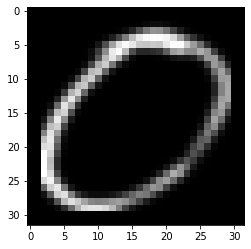

In [4]:
for digit in DIGITS:
  path = os.path.join(DATADIR,digit)
 
  for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  
        plt.show()  
        break  # Just for viewing 1 sample out of our dataset
  break  

In [5]:
img_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
training_data = []
x_train=[]
y_train=[]
def create_training_data():
    for digit in DIGITS:  # 0,1,2,3...9

        path = os.path.join(DATADIR,digit)  # create path to data
        for img in os.listdir(path):  # iterate over each image 
            try:
                x_train.append(cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE))  # convert to array
                y_train.append(int(digit))
                x = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                y=int(digit)
                training_data.append([x,y])
            except Exception as e: 
                pass
    
create_training_data()

print(len(y_train))

17000


In [7]:
len(training_data)

17000

In [8]:
import random

random.shuffle(training_data) #Shuffling our data for better training

In [9]:
for sample in training_data[:10]:
    print(sample[1])

3
5
1
2
5
5
1
3
6
4


In [10]:
X=[]
y=[]
for pic,dig in training_data:
  X.append(pic)
  y.append(dig)
#X = np.array(X).reshape(-1, 32,32, 1)

In [11]:
X[1]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 154, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 193,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [12]:
y[1]

5

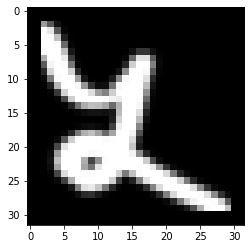

In [13]:
plt.imshow(X[1], cmap='gray')  # graph it
plt.show()  # display!

In [14]:
#CREATING NN for devnagri digit classification

In [15]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

   
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY 
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [16]:
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5  #Weights bw -.5 to .5
        self.bias = np.random.rand(1, output_size) - 0.5  

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters as per SGD
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [17]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime


    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters i.e. no weights or biases to be updated
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [18]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [19]:
#mean squared error loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [20]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [21]:
from keras.utils import np_utils
# training data : 60000 samples
# reshape and normalize input data
X = np.array(X).reshape(17000,1, 32*32)
X = X.astype('float32')
X/= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y = np_utils.to_categorical(y)
print(y.shape)

(17000, 10)


In [22]:
# Network
net = Network()
net.add(FCLayer(32*32, 100))                # input_shape=(1, 32*32)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(X[:1000], y[:1000], epochs=35, learning_rate=0.1)


epoch 1/35   error=0.246946
epoch 2/35   error=0.108393
epoch 3/35   error=0.085627
epoch 4/35   error=0.070490
epoch 5/35   error=0.059821
epoch 6/35   error=0.051521
epoch 7/35   error=0.044711
epoch 8/35   error=0.039533
epoch 9/35   error=0.035333
epoch 10/35   error=0.031485
epoch 11/35   error=0.028389
epoch 12/35   error=0.025900
epoch 13/35   error=0.023695
epoch 14/35   error=0.021713
epoch 15/35   error=0.020129
epoch 16/35   error=0.018783
epoch 17/35   error=0.017643
epoch 18/35   error=0.016581
epoch 19/35   error=0.015505
epoch 20/35   error=0.014537
epoch 21/35   error=0.013683
epoch 22/35   error=0.013015
epoch 23/35   error=0.012384
epoch 24/35   error=0.011702
epoch 25/35   error=0.011188
epoch 26/35   error=0.010796
epoch 27/35   error=0.010415
epoch 28/35   error=0.010067
epoch 29/35   error=0.009716
epoch 30/35   error=0.009456
epoch 31/35   error=0.009167
epoch 32/35   error=0.008964
epoch 33/35   error=0.008718
epoch 34/35   error=0.008474
epoch 35/35   error=0.0

In [23]:
#Testing on training data that wasn't used in training of model
out = net.predict(X[1000:1003])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y[1000:1003])



predicted values : 
[array([[-0.02055305,  0.02575007,  0.47776119, -0.07438101,  0.78325542,
         0.12615622, -0.12250772,  0.01741941,  0.18577208, -0.0413379 ]]), array([[ 0.00342469, -0.0275116 ,  0.08018164,  0.07329319,  0.0064765 ,
         0.88879858, -0.34811472,  0.81722865,  0.08582268, -0.24036131]]), array([[ 4.72777134e-03,  1.54372219e-02, -3.38972355e-02,
         8.38301743e-01,  3.67129786e-04,  5.86991379e-02,
         3.06121016e-01,  1.27967595e-02,  3.13590000e-02,
        -2.72126618e-01]])]
true values : 
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [24]:
print(np.argmax(out[0]),np.argmax(out[1]),np.argmax(out[2])) # Hence our prediction is correct

4 5 3


In [25]:
#GAN

In [26]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [27]:
(x_train, y_train), (_, _) = mnist.load_data()

print("y_train.shape",y_train.shape)
print("x_train.shape",x_train.shape)

y_train.shape (60000,)
x_train.shape (60000, 28, 28)


In [28]:
class GAN:
    def __init__(self, numbers, epochs=100, batch_size=64, input_layer_size_g=100,
                 hidden_layer_size_g=128, hidden_layer_size_d=128, learning_rate=1e-3,
                 decay_rate=1e-4, image_size=28, display_epochs=5):
       
        self.numbers = numbers # chosen numbers to be generated
        self.epochs = epochs 
        self.batch_size = batch_size  #of training examples in each batch
        self.nx_g = input_layer_size_g # #neurons in the generator's input layer
        self.nh_g = hidden_layer_size_g # #neurons in the generator's hidden layer
        self.nh_d = hidden_layer_size_d # #neurons in the discriminator's hidden layer
        self.lr = learning_rate # how much newly acquired info. overrides old info in GD
        self.dr = decay_rate # learning rate decay after every epoch
        self.image_size = image_size # # pixels of training images
        self.display_epochs = display_epochs # interval for displaying results
        
        
        
        
       

        # -------- Initialise weights with Xavier method (Basically random wights and not zero inital weights) --------#
        # -------- Generator --------#
        self.W0_g = np.random.randn(self.nx_g, self.nh_g) \
                    * np.sqrt(2. / self.nx_g)  #100x128
        self.b0_g = np.zeros((1, self.nh_g))  # 1x100

        self.W1_g = np.random.randn(self.nh_g, self.image_size ** 2) \
                    * np.sqrt(2. / self.nh_g) #128x784
        self.b1_g = np.zeros((1, self.image_size ** 2))  #1x784

        # -------- Discriminator --------#
        self.W0_d = np.random.randn(self.image_size ** 2, self.nh_d) \
                    * np.sqrt(2. / self.image_size ** 2) #784x128
        self.b0_d = np.zeros((1, self.nh_d))  # 1x128

        self.W1_d = np.random.randn(self.nh_d, 1) \
                    * np.sqrt(2. / self.nh_d)  # 128x1
        self.b1_d = np.zeros((1, 1))  # 1x1

In [29]:
def preprocess_data(self, x, y):
    x_train = []
    y_train = []

    # limit the data to a subset of digits from 0-9
    for i in range(y.shape[0]):
        if y[i] in self.numbers:
            x_train.append(x[i])
            y_train.append(y[i])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # limit the data to full batches only
    num_batches = x_train.shape[0] // self.batch_size
    x_train = x_train[: num_batches * self.batch_size]
    y_train = y_train[: num_batches * self.batch_size]
    
    # flatten the images (_,28,28)->(_, 784)
    x_train = np.reshape(x_train, (x_train.shape[0], -1))
    
    # normalise the data to the range [-1,1]
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5

    # shuffle the data
    idx = np.random.permutation(len(x_train))
    x_train, y_train = x_train[idx], y_train[idx]
    return x_train, y_train, num_batches

GAN.preprocess_data = preprocess_data

In [30]:
def lrelu(self, x, alpha=1e-2):#Set alpha=0 for Relu
    return np.maximum(x, x * alpha)

GAN.lrelu = lrelu

In [31]:
def sigmoid(self, x):
    return 1. / (1. + np.exp(-x))

GAN.sigmoid = sigmoid

In [32]:
def dlrelu(self, x, alpha=1e-2):
    dx = np.ones_like(x)#As x>0 slope=1
    dx[x < 0] = alpha#x<0 slope alpha
    return dx

GAN.dlrelu = dlrelu

In [33]:
def dsigmoid(self, x):
    y = self.sigmoid(x)
    return y * (1. -y)

GAN.dsigmoid = dsigmoid

In [34]:
def dtanh(self, x):
    return 1. - np.tanh(x)** 2

GAN.dtanh = dtanh

In [35]:
def forward_generator(self, z):
    self.z0_g = np.dot(z, self.W0_g) + self.b0_g
    self.a0_g = self.lrelu(self.z0_g, alpha=0)

    self.z1_g = np.dot(self.a0_g, self.W1_g) + self.b1_g
    self.a1_g = np.tanh(self.z1_g)  # range [-1,1]
    return self.z1_g, self.a1_g

GAN.forward_generator = forward_generator

In [36]:
def forward_discriminator(self, x):
    self.z0_d = np.dot(x, self.W0_d) + self.b0_d
    self.a0_d = self.lrelu(self.z0_d)

    self.z1_d = np.dot(self.a0_d, self.W1_d) + self.b1_d
    self.a1_d = self.sigmoid(self.z1_d)  # output probability [0,1]
    return self.z1_d, self.a1_d

GAN.forward_discriminator = forward_discriminator

In [37]:
def backward_discriminator(self, x_real, z1_real, a1_real, x_fake, z1_fake, a1_fake):
    # -------- Backprop through Discriminator --------#
    # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))
    
    # real input gradients -np.log(a1_real)
    da1_real = -1. / (a1_real + 1e-8)  # 64x1

    dz1_real = da1_real * self.dsigmoid(z1_real)  # 64x1
    dW1_real = np.dot(self.a0_d.T, dz1_real)
    db1_real = np.sum(dz1_real, axis=0, keepdims=True)

    da0_real = np.dot(dz1_real, self.W1_d.T)
    dz0_real = da0_real * self.dlrelu(self.z0_d)
    dW0_real = np.dot(x_real.T, dz0_real)
    db0_real = np.sum(dz0_real, axis=0, keepdims=True)

    # fake input gradients -np.log(1 - a1_fake)
    da1_fake = 1. / (1. - a1_fake + 1e-8)

    dz1_fake = da1_fake * self.dsigmoid(z1_fake)
    dW1_fake = np.dot(self.a0_d.T, dz1_fake)
    db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)

    da0_fake = np.dot(dz1_fake, self.W1_d.T)
    dz0_fake = da0_fake * self.dlrelu(self.z0_d, alpha=0)
    dW0_fake = np.dot(x_fake.T, dz0_fake)
    db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

    # -------- Combine gradients for real & fake images--------#
    dW1 = dW1_real + dW1_fake
    db1 = db1_real + db1_fake

    dW0 = dW0_real + dW0_fake
    db0 = db0_real + db0_fake

    # -------- Update gradients using SGD--------#
    self.W0_d -= self.lr * dW0
    self.b0_d -= self.lr * db0

    self.W1_d -= self.lr * dW1
    self.b1_d -= self.lr * db1
    
GAN.backward_discriminator = backward_discriminator

In [38]:
def backward_generator(self, z, x_fake, z1_fake, a1_fake):
    # -------- Backprop through Discriminator --------#
    # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))
    
    # fake input gradients -np.log(1 - a1_fake)
    da1_d = -1.0 / (a1_fake + 1e-8)  # 64x1

    dz1_d = da1_d * self.dsigmoid(z1_fake)
    da0_d = np.dot(dz1_d, self.W1_d.T)
    dz0_d = da0_d * self.dlrelu(self.z0_d)
    dx_d = np.dot(dz0_d, self.W0_d.T)

    # -------- Backprop through Generator --------#
    # J_G = np.mean(-np.log(1 - a1_fake))
    dz1_g = dx_d * self.dtanh(self.z1_g)
    dW1_g = np.dot(self.a0_g.T, dz1_g)
    db1_g = np.sum(dz1_g, axis=0, keepdims=True)

    da0_g = np.dot(dz1_g, self.W1_g.T)
    dz0_g = da0_g * self.dlrelu(self.z0_g, alpha=0)
    dW0_g = np.dot(z.T, dz0_g)
    db0_g = np.sum(dz0_g, axis=0, keepdims=True)

    # -------- Update gradients using SGD --------#
    self.W0_g -= self.lr * dW0_g
    self.b0_g -= self.lr * db0_g

    self.W1_g -= self.lr * dW1_g
    self.b1_g -= self.lr * db1_g
    
GAN.backward_generator = backward_generator

In [39]:
def sample_images(self, images, epoch, show):
    images = np.reshape(images, (self.batch_size, self.image_size, self.image_size))
    
    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    if show == True:
         plt.show()
    else:
         plt.close()

GAN.sample_images = sample_images

In [40]:
def train(self, x, y):
    J_Ds = []  # stores the disciminator losses
    J_Gs = []  # stores the generator losses

    # preprocess input; note that the labels aren't needed
    x_train, _, num_batches = self.preprocess_data(x, y)

    for epoch in range(self.epochs):
        for i in range(num_batches):
            # ------- PREPARE INPUT BATCHES & NOISE -------#
            x_real = x_train[i * self.batch_size: (i + 1) * self.batch_size] # 64x784
            z = np.random.normal(0, 1, size=[self.batch_size, self.nx_g])  # 64x100

            # ------- FORWARD PROPAGATION -------#
            z1_g, x_fake = self.forward_generator(z)

            z1_d_real, a1_d_real = self.forward_discriminator(x_real)
            z1_d_fake, a1_d_fake = self.forward_discriminator(x_fake)

            # ------- CROSS ENTROPY LOSS -------#
            # ver1 : max log(D(x)) + log(1 - D(G(z))) (in original paper)
            # ver2 : min -log(D(x)) min -log(1 - D(G(z))) (implemented here)
            J_D = np.mean(-np.log(a1_d_real) - np.log(1 - a1_d_fake))
            J_Ds.append(J_D)

            # ver1 : minimize log(1 - D(G(z))) (in original paper)
            # ver2 : maximize log(D(G(z)))
            # ver3 : minimize -log(D(G(z))) (implemented here)
            J_G = np.mean(-np.log(a1_d_fake))
            J_Gs.append(J_G)
            # ------- BACKWARD PROPAGATION -------#
            self.backward_discriminator(x_real, z1_d_real, a1_d_real,
                                        x_fake, z1_d_fake, a1_d_fake)
            self.backward_generator(z, x_fake, z1_d_fake, a1_d_fake)

        if epoch % self.display_epochs == 0:
            print(f"Epoch:{epoch:}|G loss:{J_G:.4f}|D loss:{J_D:.4f}|D(G(z))avg:{np.mean(a1_d_fake):.4f}|D(x)avg:{np.mean(a1_d_real):.4f}|LR:{self.lr:.6f}")
            self.sample_images(x_fake, epoch, show=True) # display sample images
        else:
            self.sample_images(x_fake, epoch, show=False)

        # reduce learning rate after every epoch
        self.lr = self.lr * (1.0 / (1.0 + self.dr * epoch))

        
    return J_Ds, J_Gs

GAN.train = train

Epoch:0|G loss:0.7678|D loss:1.2438|D(G(z))avg:0.4644|D(x)avg:0.5387|LR:0.001000


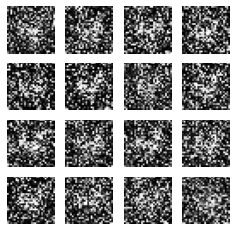

Epoch:5|G loss:0.7813|D loss:1.2000|D(G(z))avg:0.4581|D(x)avg:0.5564|LR:0.000999


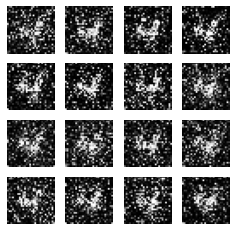

Epoch:10|G loss:0.7317|D loss:1.3122|D(G(z))avg:0.4813|D(x)avg:0.5197|LR:0.000996


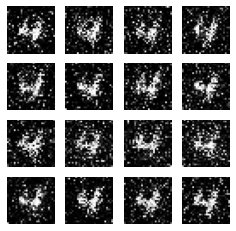

Epoch:15|G loss:0.7001|D loss:1.3729|D(G(z))avg:0.4967|D(x)avg:0.5040|LR:0.000990


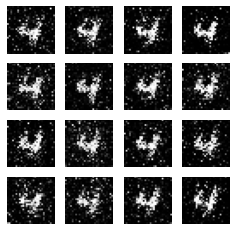

Epoch:20|G loss:0.6894|D loss:1.4026|D(G(z))avg:0.5020|D(x)avg:0.4945|LR:0.000981


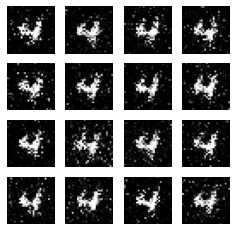

Epoch:25|G loss:0.6767|D loss:1.4239|D(G(z))avg:0.5083|D(x)avg:0.4902|LR:0.000970


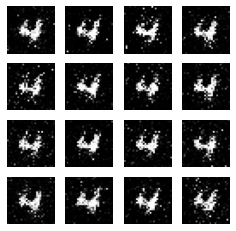

Epoch:30|G loss:0.6703|D loss:1.4364|D(G(z))avg:0.5116|D(x)avg:0.4873|LR:0.000957


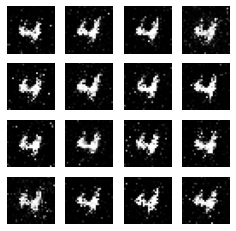

Epoch:35|G loss:0.6653|D loss:1.4440|D(G(z))avg:0.5141|D(x)avg:0.4861|LR:0.000942


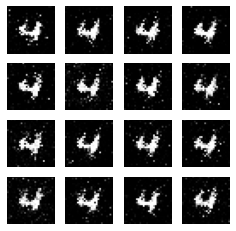

Epoch:40|G loss:0.6641|D loss:1.4459|D(G(z))avg:0.5147|D(x)avg:0.4858|LR:0.000925


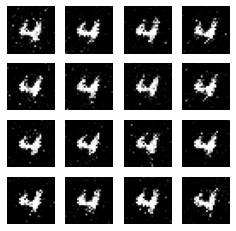

Epoch:45|G loss:0.6669|D loss:1.4407|D(G(z))avg:0.5133|D(x)avg:0.4869|LR:0.000906


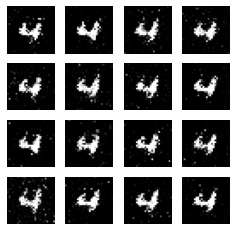

Epoch:50|G loss:0.6701|D loss:1.4333|D(G(z))avg:0.5117|D(x)avg:0.4888|LR:0.000885


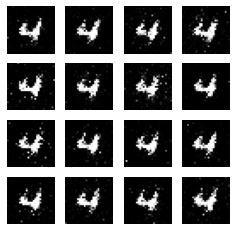

Epoch:55|G loss:0.6766|D loss:1.4204|D(G(z))avg:0.5083|D(x)avg:0.4918|LR:0.000862


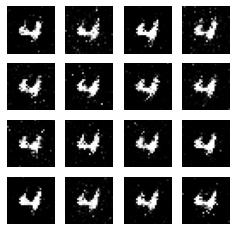

Epoch:60|G loss:0.6833|D loss:1.4059|D(G(z))avg:0.5049|D(x)avg:0.4954|LR:0.000838


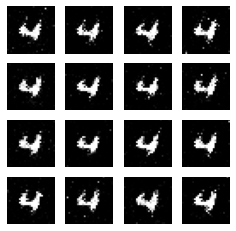

Epoch:65|G loss:0.6940|D loss:1.3857|D(G(z))avg:0.4996|D(x)avg:0.5002|LR:0.000813


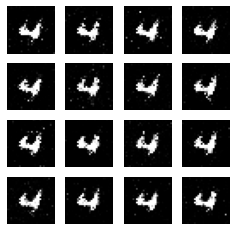

Epoch:70|G loss:0.7062|D loss:1.3633|D(G(z))avg:0.4935|D(x)avg:0.5054|LR:0.000786


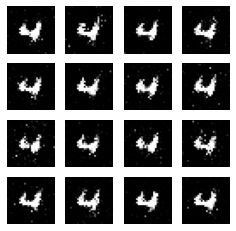

Epoch:75|G loss:0.7176|D loss:1.3409|D(G(z))avg:0.4879|D(x)avg:0.5111|LR:0.000758


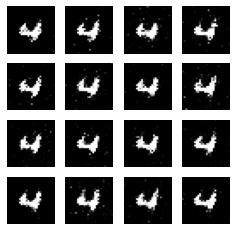

Epoch:80|G loss:0.7307|D loss:1.3168|D(G(z))avg:0.4816|D(x)avg:0.5172|LR:0.000730


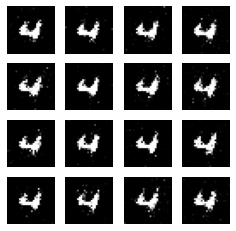

Epoch:85|G loss:0.7443|D loss:1.2931|D(G(z))avg:0.4751|D(x)avg:0.5231|LR:0.000700


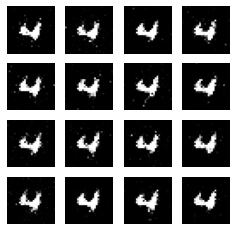

Epoch:90|G loss:0.7570|D loss:1.2713|D(G(z))avg:0.4691|D(x)avg:0.5286|LR:0.000671


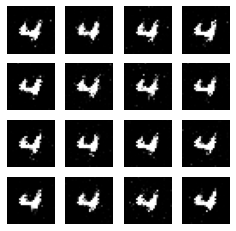

Epoch:95|G loss:0.7684|D loss:1.2503|D(G(z))avg:0.4638|D(x)avg:0.5345|LR:0.000641


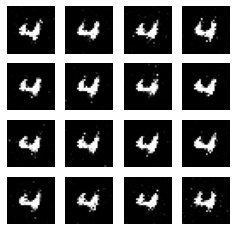

In [41]:
numbers = [np.argmax(out[0])]
model = GAN(numbers, learning_rate = 1e-3, decay_rate = 1e-4, epochs = 100)
J_Ds, J_Gs = model.train(x_train, y_train)

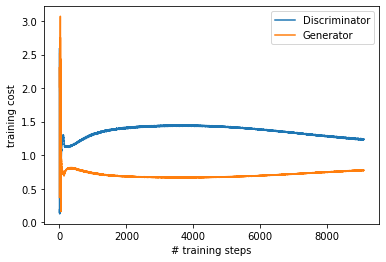

In [42]:
plt.plot([i for i in range(len(J_Ds))], J_Ds)
plt.plot([i for i in range(len(J_Gs))], J_Gs)

plt.xlabel("# training steps")
plt.ylabel("training cost")
plt.legend(['Discriminator', 'Generator'])
plt.show()